# Modeling Training and Deployment

In [1]:
import os
import re

import pandas as pd
import numpy as np
from functions import *

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, confusion_matrix

from imblearn.over_sampling import SMOTE

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 

import matplotlib.pyplot as plt

## Exploratory Data Analysis  

In [2]:
df = pd.read_csv('data/archive_train.csv')
df.dropna(inplace=True)

df_most_shared = load_most_shared('data/most_popular_train')
df.date_published = df.date_published.apply(lambda x: pd.to_datetime(x).date())

In [3]:
popular_list = df_most_shared.uri.values
df['popular'] = [1 if x in popular_list else 0 for x in df['uri']]

In [4]:
df.head()

,uri,date_published,headline,keywords,snippet,word_count,popular
0,nyt://article/4e2abcbc-9563-56c0-bf18-c93ce4e7...,2021-12-01,let’s end the covid blame games,coronavirus omicron variantcoronavirus (2019-n...,"Finger pointing is pointless, divisive and dumb.",918,0
1,nyt://article/f7a5e7ef-e4cd-575c-a0e1-ff4d18d5...,2021-12-01,trump’s iran policy has become a disaster for ...,irannuclear weaponsembargoes and sanctionsunit...,Withdrawing from the Iran nuclear deal was a m...,1560,0
2,nyt://article/778af86c-b600-5aeb-be98-0a9a1aa1...,2021-12-01,this extinct eagle may have gulped guts like a...,eagles (birds)vultures (birds)condorsendangere...,Scientists suggest the largest eagle that ever...,913,0
3,nyt://article/fb7763c2-0f41-5c81-9ecf-17607ba5...,2021-12-01,republican recriminations point to a rocky pat...,republican partyhouse of representativesboeber...,Simmering tensions between the far-right flank...,1172,0
4,nyt://article/ba0afd37-0c00-5535-8868-21130e28...,2021-12-01,a times editor who attended oxford recalls a d...,school shootings and armed attacks,Three teenage students were killed on Tuesday ...,309,0


In [5]:
df.date_published[0]

datetime.date(2021, 12, 1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4693 entries, 0 to 5233
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uri             4693 non-null   object
 1   date_published  4693 non-null   object
 2   headline        4693 non-null   object
 3   keywords        4693 non-null   object
 4   snippet         4693 non-null   object
 5   word_count      4693 non-null   int64 
 6   popular         4693 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 453.3+ KB


In [7]:
df.popular.value_counts(normalize=True)

0    0.98615
1    0.01385
Name: popular, dtype: float64

## Train-Test Split

In [8]:
X = df.drop('popular', axis=1)
y = df.popular

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

## Dummy classifier

In [10]:
dummy = DummyClassifier(random_state=0, strategy='stratified') 

#establishing random_state for reproducibility

dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

In [11]:
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))

Accuracy Score: 0.9770017035775128


In [12]:
dummy_prob = dummy.predict_proba(X_test)
dummy_prob = [x[1] for x in dummy_prob if x[1] == 1]
len(dummy_prob)

17

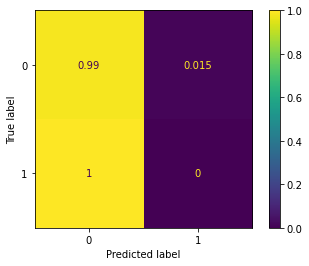

In [13]:
plot_confusion_matrix(estimator=dummy, X=X_test, y_true=y_test, normalize='true');

## Data Preprocessing 

#### Headline

##### TfidfVectorizer

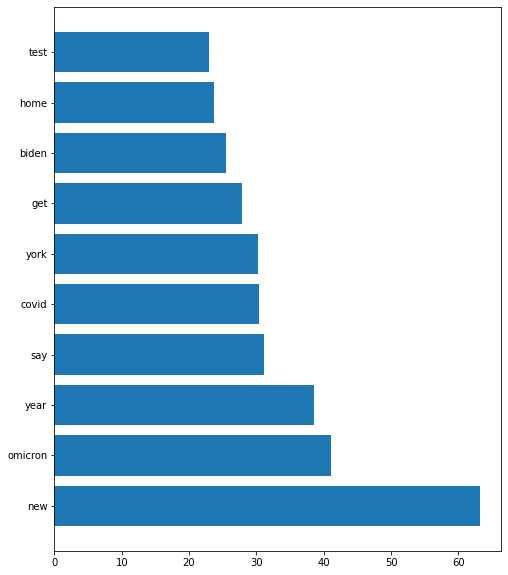

In [14]:
headline_tf, X_train_headline_tf, X_test_headline_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.headline, X_test.headline)

X_train_headline_tf, X_test_headline_tf = vector_tokenized(headline_tf, X_train.headline, X_test.headline)


X_train_headline_tf_sm, y_train_headline_tf_sm = smote_data(X_train_headline_tf, y_train, 
                                                  sampling_strategy='auto',random_state=0)

# used later: X_train_headline_tf_sm, y_train_headline_tf_sm, X_test_headline_tf

plot_top_words(headline_tf, X_train_headline_tf);

##### CountVectorizer

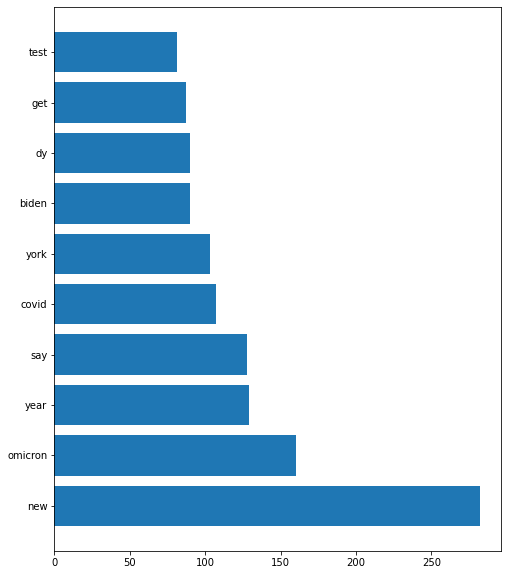

In [15]:
headline_cv, X_train_headline_cv, X_test_headline_cv = vectorize_feature(CountVectorizer, 
                                                                         X_train.headline, X_test.headline)

X_train_headline_cv, X_test_headline_cv = vector_tokenized(headline_cv, X_train.headline, X_test.headline)

X_train_headline_cv_sm, y_train_headline_cv_sm = smote_data(X_train_headline_cv, y_train, 
                                                  sampling_strategy='auto',random_state=0)

# used later: X_train_headline_cv_sm, y_train_headline_cv_sm, X_test_headline_cv

plot_top_words(headline_cv, X_train_headline_cv);

#### Keywords

##### TfidfVectorizer

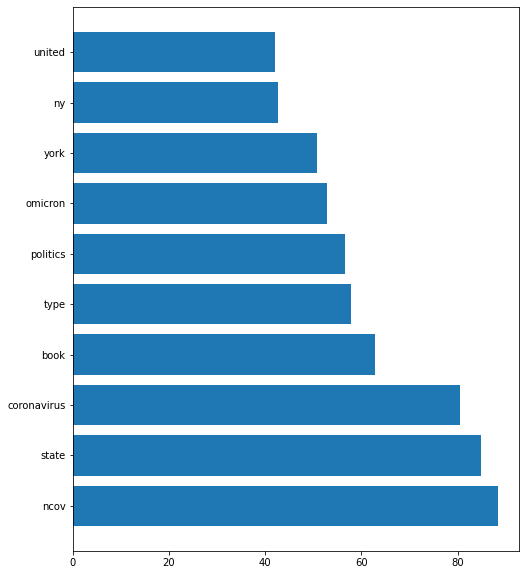

In [16]:
keywords_tf, X_train_keywords_tf, X_test_keywords_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.keywords, X_test.keywords)

X_train_keywords_tf, X_test_keywords_tf = vector_tokenized(keywords_tf, X_train.keywords, X_test.keywords)

X_train_keywords_tf_sm, y_train_keywords_tf_sm = smote_data(X_train_keywords_tf, y_train, 
                                                  sampling_strategy='auto',random_state=0)

# used later: X_train_keywords_tf_sm, y_train_keywords_tf_sm, X_test_keywords_tf

plot_top_words(keywords_tf, X_train_keywords_tf);

##### CountVectorizer

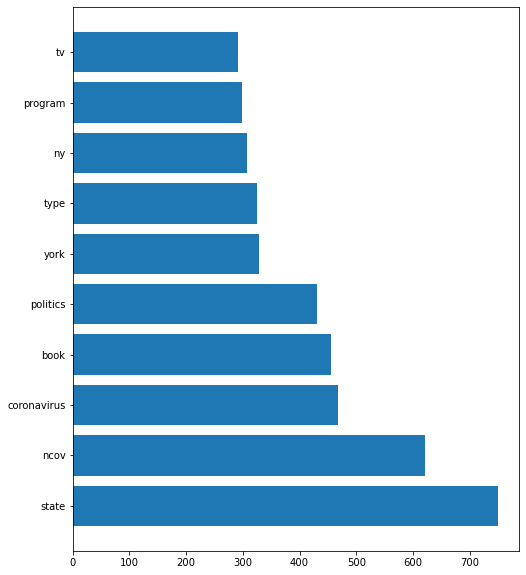

In [17]:
keywords_cv, X_train_keywords_cv, X_test_keywords_cv = vectorize_feature(CountVectorizer, 
                                                                         X_train.keywords, X_test.keywords)

X_train_keywords_cv, X_test_keywords_cv = vector_tokenized(keywords_cv, X_train.keywords, X_test.keywords)

X_train_keywords_cv_sm, y_train_keywords_cv_sm = smote_data(X_train_keywords_cv, y_train, 
                                                  sampling_strategy='auto',random_state=0)

# used later: X_train_keywords_cv_sm, y_train_keywords_cv_sm, X_test_keywords_cv

plot_top_words(keywords_cv, X_train_keywords_cv);

#### Snippet

##### TfidfVectorizer

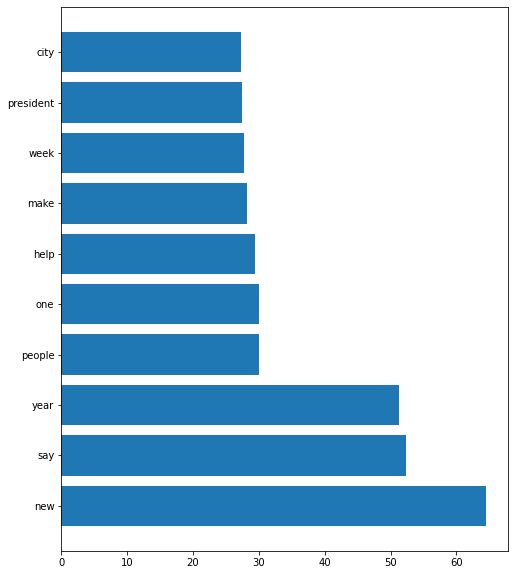

In [18]:
snippet_tf, X_train_snippet_tf, X_test_snippet_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.snippet, X_test.snippet)

X_train_snippet_tf, X_test_snippet_tf = vector_tokenized(snippet_tf, X_train.snippet, X_test.snippet)

X_train_snippet_tf_sm, y_train_snippet_tf_sm = smote_data(X_train_snippet_tf, y_train, 
                                                  sampling_strategy='auto',random_state=0)

# used later: X_train_snippet_tf_sm, y_train_snippet_tf_sm, X_test_snippet_tf

plot_top_words(snippet_tf, X_train_snippet_tf);

##### CountVectorizer

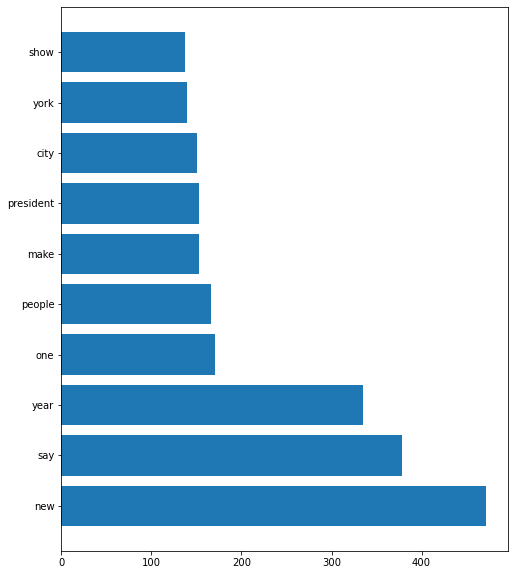

In [19]:
snippet_cv, X_train_snippet_cv, X_test_snippet_cv = vectorize_feature(CountVectorizer, 
                                                                         X_train.snippet, X_test.snippet)

X_train_snippet_cv, X_test_snippet_cv = vector_tokenized(snippet_cv, X_train.snippet, X_test.snippet)

X_train_snippet_cv_sm, y_train_snippet_cv_sm = smote_data(X_train_snippet_cv, y_train, 
                                                  sampling_strategy='auto',random_state=0)

# used later: X_train_snippet_cv_sm, y_train_snippet_cv_sm, X_test_snippet_cv

plot_top_words(snippet_cv, X_train_snippet_cv);

#### Word Count

In [20]:
X_train_word_count_sm, y_train_word_count_sm = smote_data(X_train.word_count.values.reshape(-1, 1), 
                                                          y_train, sampling_strategy='auto',
                                                          random_state=0)

## Model Training

In [21]:
def random_forrest_tf(X_train, y_train, X_test, y_test):
    
    forrest = RandomForestClassifier()
    grid = {'n_estimators': [50,75,100]}
    
    gs = GridSearchCV(estimator=forrest, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)

    score = gs.score(X_test, y_test)
    print(f'mean accuracy: {score}')
    
    class_probability = gs.predict_proba(X_test)
    target_probability = [x[1] for x in class_probability]
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plt.title('ROC Curve')
    plot_roc_curve(gs, X_train, y_train, name='Train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='Test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test)
    
    return target_probability

In [ ]:
def random_forrest_cv(X_train, y_train, X_test, y_test):
    
    forrest = RandomForestClassifier()
    grid = {'n_estimators': [50,75,100]}
    
    gs = GridSearchCV(estimator=forrest, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)

    score = gs.score(X_test, y_test)
    print(f'mean accuracy: {score}')
    
    class_probability = gs.predict_proba(X_test)
    target_probability = [x[1] for x in class_probability]
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plt.title('ROC Curve')
    plot_roc_curve(gs, X_train, y_train, name='Train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='Test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test)
    
    return target_probability

In [36]:
forrest = RandomForestClassifier()
grid = {'n_estimators': [50,75,100]}
gs = GridSearchCV(estimator=forrest, param_grid=grid, cv=5, scoring='accuracy')
gs.fit(X_train_headline_cv_sm, y_train_headline_cv_sm)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [50, 75, 100]}, scoring='accuracy')

In [37]:
y_pred = gs.predict(X_test_headline_cv)

In [39]:
len(y_pred)

1174

In [40]:
accuracy_score(y_test, y_pred)

0.74190800681431

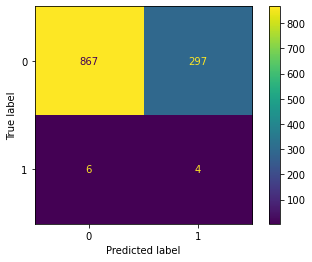

In [41]:
plot_confusion_matrix(gs, X_test_headline_cv, y_test)

### Headline

##### TfidfVectorizer

mean accuracy: 0.9914821124361158
number of probabilities: 1174



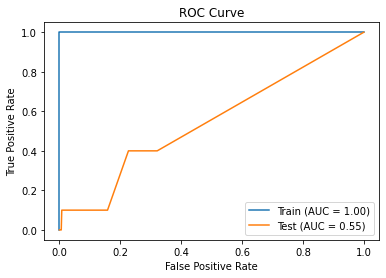

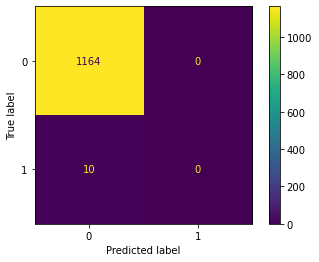

In [22]:
headline_tf_prob = random_forrest(X_train_headline_tf_sm, y_train_headline_tf_sm, X_test_headline_tf, y_test)
print(f'number of probabilities: {len(headline_tf_prob)}')
print()

##### CountVectorizer

mean accuracy: 0.7367972742759795
number of probabilities: 1174



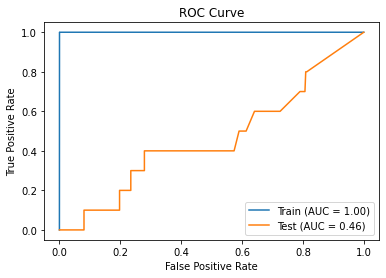

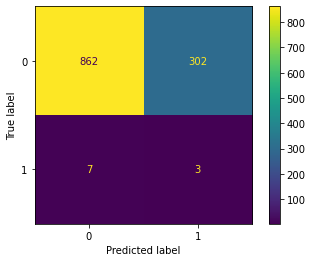

In [23]:
headline_cv_prob = random_forrest(X_train_headline_cv_sm, y_train_headline_cv_sm, X_test_headline_cv, y_test)
print(f'number of probabilities: {len(headline_cv_prob)}')
print()

### Keywords

##### TfidfVectorizer

mean accuracy: 0.9906303236797275
number of probabilities: 1174



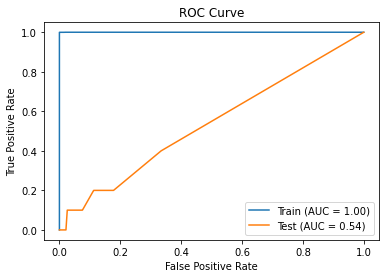

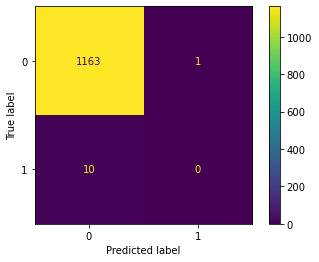

In [24]:
keywords_tf_prob = random_forrest(X_train_keywords_tf_sm, y_train_keywords_tf_sm, X_test_keywords_tf, y_test)
print(f'number of probabilities: {len(keywords_tf_prob)}')
print()

##### CountVectorizer

mean accuracy: 0.8253833049403748
number of probabilities: 1174



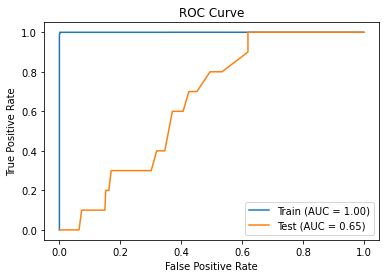

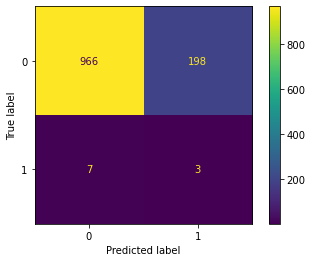

In [25]:
keywords_cv_prob = random_forrest(X_train_keywords_cv_sm, y_train_keywords_cv_sm, X_test_keywords_cv, y_test)
print(f'number of probabilities: {len(keywords_cv_prob)}')
print()

### Snippet 

##### TfidfVectorizer

mean accuracy: 0.9914821124361158
number of probabilities: 1174



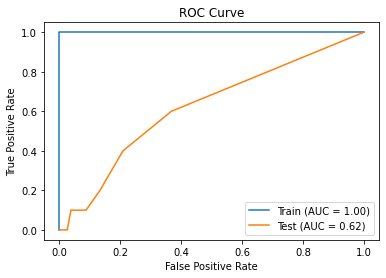

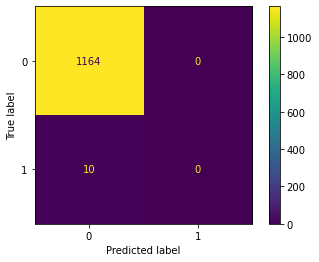

In [26]:
snippet_tf_prob = random_forrest(X_train_snippet_tf_sm, y_train_snippet_tf_sm, X_test_snippet_tf, y_test)
print(f'number of probabilities: {len(snippet_tf_prob)}')
print()

##### CountVectorizer

mean accuracy: 0.8637137989778535
number of probabilities: 1174



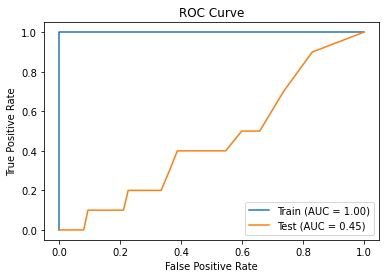

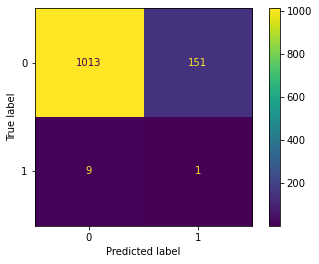

In [27]:
snippet_cv_prob = random_forrest(X_train_snippet_cv_sm, y_train_snippet_cv_sm, X_test_snippet_cv, y_test)
print(f'number of probabilities: {len(snippet_cv_prob)}')
print()

## Word Count Logistic

In [28]:
clf_word_count = LogisticRegression()

In [29]:
clf_word_count.fit(X_train_word_count_sm, y_train_word_count_sm)

LogisticRegression()

In [30]:
word_count_prob = clf_word_count.predict_proba(X_test.word_count.values.reshape(-1, 1))
word_count_prob = [x[1] for x in word_count_prob]
len(word_count_prob)

1174

In [31]:
clf_word_count.score(X_test.word_count.values.reshape(-1, 1), y_test)

0.530664395229983

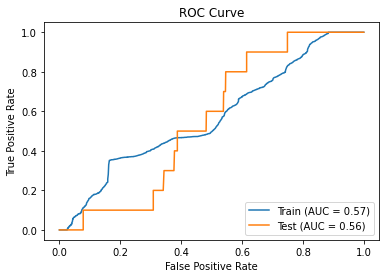

In [32]:
# Plot an ROC curve (only works with binary data)
fig, ax = plt.subplots()
plt.title('ROC Curve')
plot_roc_curve(clf_word_count, X_train_word_count_sm, y_train_word_count_sm, name='Train', ax=ax)
plot_roc_curve(clf_word_count, X_test.word_count.values.reshape(-1, 1), y_test, name='Test', ax=ax);

### Logistic Regression

##### Cleaning

In [33]:
df_predict_tf = pd.DataFrame({'headline_prob': headline_tf_prob, 
                           'keywords_prob': keywords_tf_prob, 
                           'snippet_prob': snippet_tf_prob,
                           'word_count_prob': word_count_prob, 
                           'popular': y_test})

In [34]:
df_predict_tf.head()

,headline_prob,keywords_prob,snippet_prob,word_count_prob,popular
3934,0.01,0.000000,0.0,0.476415,0
604,0.01,0.133333,0.0,0.546910,0
48,0.00,0.013333,0.0,0.481230,0
963,0.00,0.000000,0.0,0.468326,0
2167,0.00,0.000000,0.0,0.495125,0


In [35]:
df_predict.info()

NameError: name 'df_predict' is not defined

In [ ]:
df_predict_tf.popular.value_counts(normalize=True)

In [ ]:
df_predict_cv = pd.DataFrame({'headline_prob': headline_cv_prob, 
                           'keywords_prob': keywords_cv_prob, 
                           'snippet_prob': snippet_cv_prob,
                           'word_count_prob': word_count_prob, 
                           'popular': y_test})

In [ ]:
df_predict_cv.head()

In [ ]:
df_predict_cv.info()

In [ ]:
df_predict_cv.popular.value_counts(normalize=True)

##### Modeling

In [ ]:
features_tf = df_predict_tf.drop('popular', axis=1)
target_tf = df_predict_tf.popular

In [ ]:
clf_tf = LogisticRegression()

In [ ]:
clf_tf.fit(features_tf, target_tf)

In [ ]:
# clf_tf.predict_proba()

In [ ]:
features_cv = df_predict_cv.drop('popular', axis=1)
target_cv = df_predict_cv.popular

In [ ]:
clf_cv = LogisticRegression()

In [ ]:
clf_cv.fit(features_cv, target_cv)

In [ ]:
# clf_tf.predict_proba()

In [ ]:
# y_hat = pd.Series(clf.predict(features))

In [ ]:
# y_hat.value_counts()

In [ ]:
# X_test.uri.index

In [ ]:
# index = X_test.uri.index

In [ ]:
# test_df = pd.DataFrame({'uri': X_test.uri, 'popular':y_hat}, index=index)

In [ ]:
# test_df.head()

In [ ]:
# test_df.popular.value_counts()

## Model Deployment